# Credit Analysis: A Classification Problem
---

## 1. Introduction

Credit analysis is a critical service in financial ecosystems, helping to assess and mitigate the risk of granting credit to potential borrowers. This project utilizes data from 1,319 credit card applications, detailed with 12 variables including credit acceptance, financial behavior reports, income, and expenditure ratios. The dataset is derived from the exemplary work found in G.W. Greene's "Econometric Analysis, 5th edition."

The main objectives of this study are:
1. To understand the current credit analysis process and identify potential areas for improvement.
2. To develop a classification model that delivers more accurate and effective outcomes than existing methodologies.

This project aims not just to predict creditworthiness but also to enhance the decision-making process in financial lending practices. For additional data insights, please refer to the detailed dataset documentation available at [here](https://vincentarelbundock.github.io/Rdatasets/doc/AER/CreditCard.html).

---

## 2. Data Cleaning and Exploration

To start, I'll import just basic libraries used for data manipulation, visualization, and statistical tests, aiming to accomplish my first objective.

In [156]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Then, I'll import the data and return a sample of it, along with information about datatypes, null values, and descriptive measures for numeric columns:

In [157]:
# Storing data and showing basic information
path = os.path.abspath('../data/CreditCard.csv')
df = pd.read_csv(path)
df.sample(10), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rownames     1319 non-null   int64  
 1   card         1319 non-null   object 
 2   reports      1319 non-null   int64  
 3   age          1319 non-null   float64
 4   income       1319 non-null   float64
 5   share        1319 non-null   float64
 6   expenditure  1319 non-null   float64
 7   owner        1319 non-null   object 
 8   selfemp      1319 non-null   object 
 9   dependents   1319 non-null   int64  
 10  months       1319 non-null   int64  
 11  majorcards   1319 non-null   int64  
 12  active       1319 non-null   int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 134.1+ KB


(     rownames card  reports       age  income     share  expenditure owner  \
 101       102   no        0  35.00000    4.55  0.000264     0.000000   yes   
 981       982  yes        1  58.91667    2.70  0.003222     6.416667   yes   
 358       359  yes        0  32.58333   10.00  0.099808   831.731700   yes   
 854       855   no        1  24.58333    1.90  0.000632     0.000000    no   
 240       241  yes        1  41.83333    5.00  0.150108   625.367500   yes   
 141       142  yes        0  41.50000    3.80  0.083156   263.327500    no   
 373       374  yes        0  33.08333    4.50  0.104378   391.417500    no   
 851       852  yes        0  34.58333    7.00  0.035465   206.381700    no   
 459       460  yes        1  30.00000    4.00  0.051054   170.180800   yes   
 564       565  yes        0  34.83333    4.00  0.258252   860.755000    no   
 
     selfemp  dependents  months  majorcards  active  
 101      no           3      36           1      15  
 981      no       

Some things to mention:
- There are **no null values in the data (yay!)**
- Datatypes look correct, but **binary columns can become numerical**
- **Rownames should be dropped**
- From the columns that were described, **all but majorcards seem to have outliers:**
    - Outliers for income and dependents are reasonable, but I'd like to give a further look to when income is close to 0
    - Outliers for when age is 0 or close don't make sense.
        - Depending on their %, I'll either drop them or replace them for a minimal age, like 18.
    - Outliers for share or expenditure indicate people who are spending more than they earn, which possibly shows a misclassification from the current model.
    - Outliers for reports or active seem reasonable as well, but I'd like to guve a further look

Now, I'll describe the columns that are still objects

In [158]:
# Selecting object coluns, mapping them to 1/0, and describing them
df.select_dtypes('object').apply(lambda col: col.replace({'yes': 1, 'no': 0})).describe()

,card,owner,selfemp
count,1319.000000,1319.000000,1319.000000
mean,0.775588,0.440485,0.068992
std,0.417353,0.496634,0.253536
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


Other things to mention:
- **Card is unbalanced** and probably will need balancing when training the model.
- Owner and selfemp are ok

Now I'll quickly drop rownames and convert categorical columns to numerical.   

In [159]:
# dropping rownames
df.drop('rownames', axis=1, inplace=True)

In [160]:
df['card'] = (df['card']=='yes').astype(int)
df['owner'] = (df['owner']=='yes').astype(int)
df['selfemp'] = (df['selfemp']=='yes').astype(int)

# Showing if all transformations were performed correctly
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,1,0,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,0,0,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,1,0,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,0,0,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,1,0,2,64,1,5


With all being done correctly, I'd like to **visualize the data distribution for each column** before I deal with outliers and age.

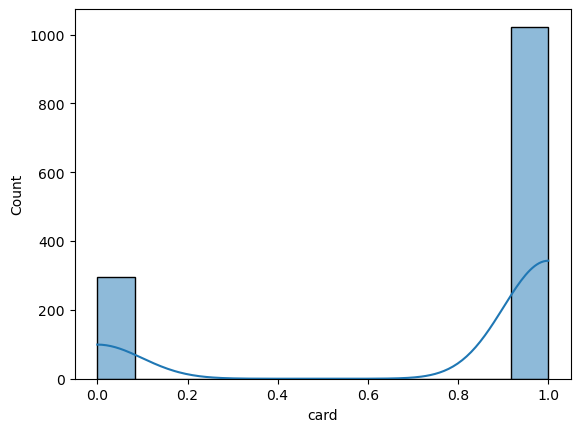

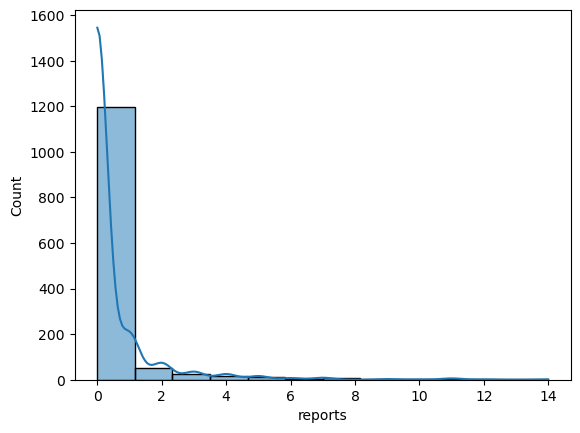

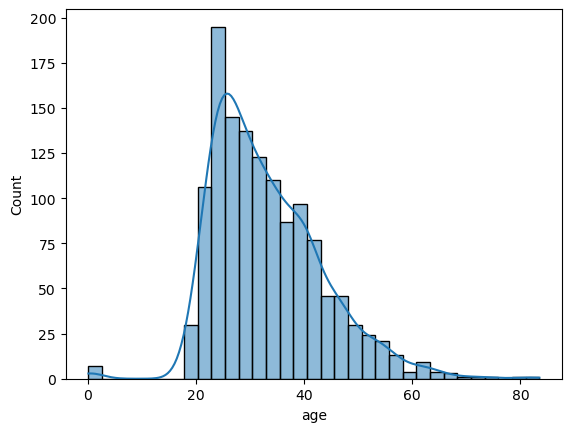

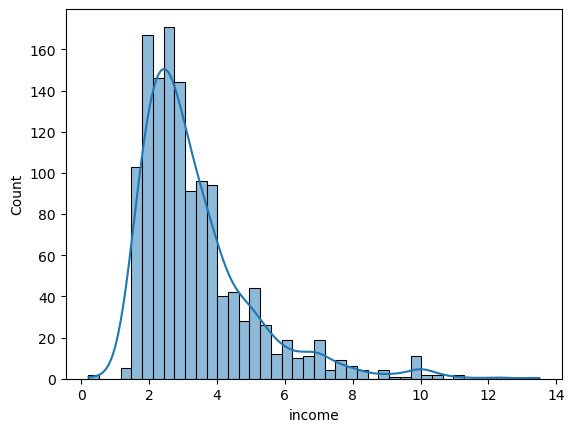

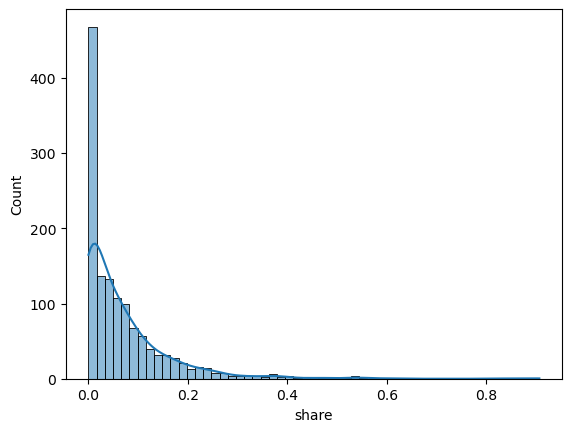

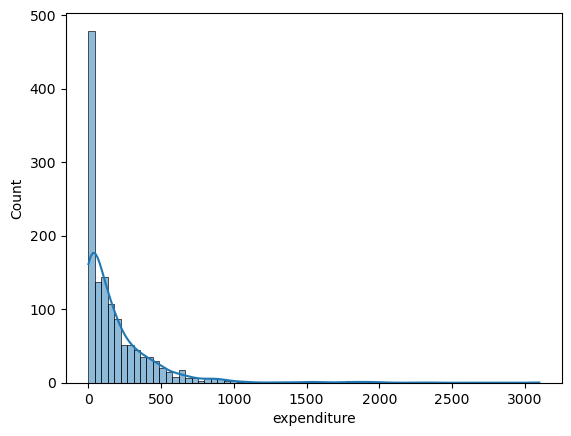

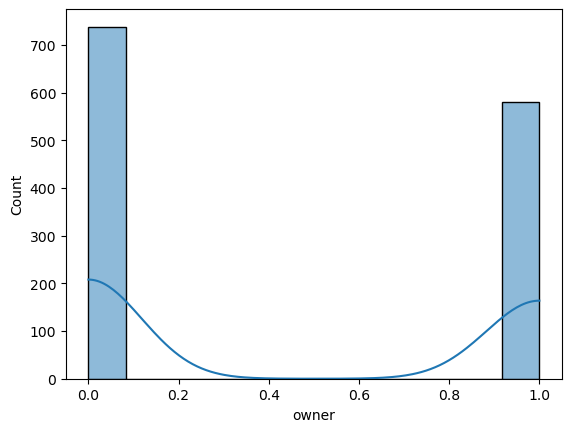

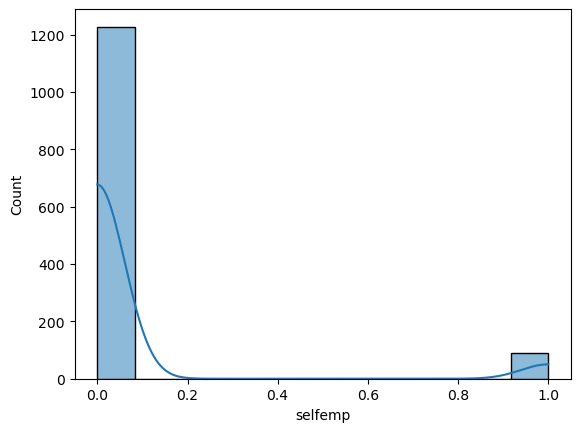

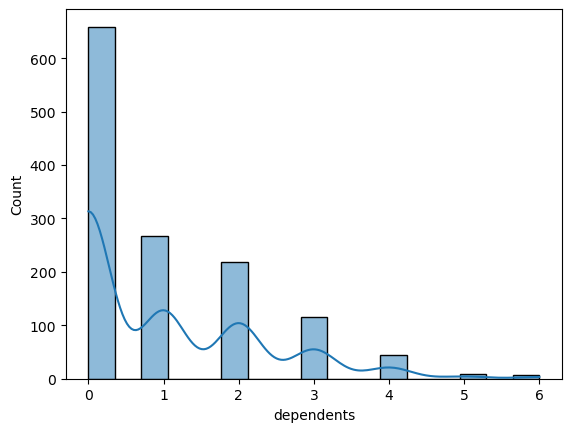

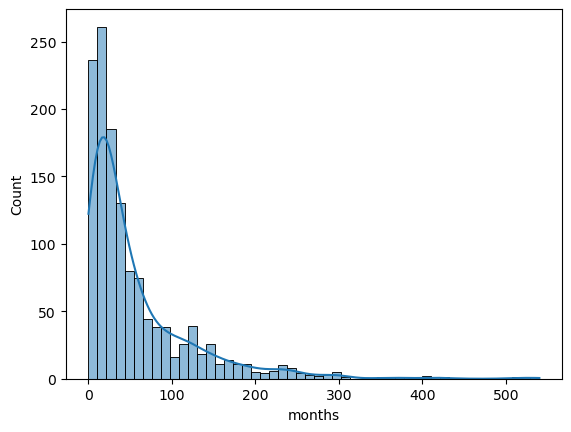

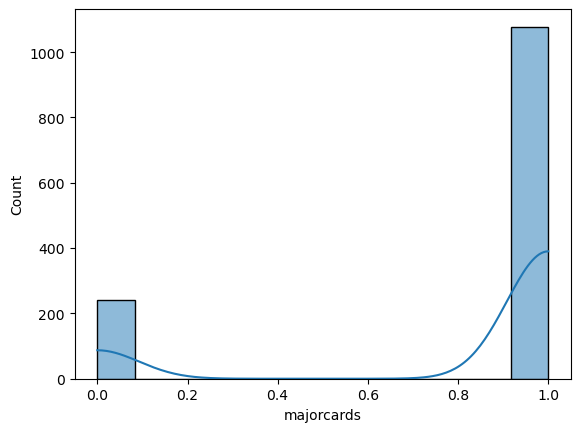

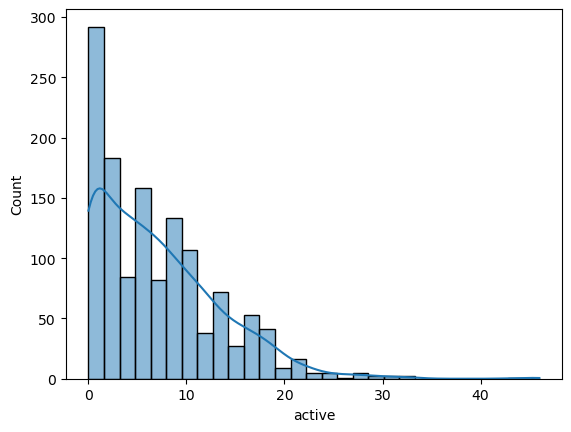

In [161]:
for col in df.columns:
    sns.histplot(df[col], kde=True)
    plt.show()

Most distributions are **skewed to the right.** I might come back here to see if this will impact my predictions   
Also, again, age and income also have some data points to the left of the mode. I'll analyse them now.

In [162]:
# Creating a dict with column name and possible thresholds observed in the histogram
low_outliers = {'age': 18, 'income': 1.5}
for col, threshold in low_outliers.items():
    print(df.loc[df[col] < threshold, :])
    print('----------')

      card  reports       age  income     share  expenditure  owner  selfemp  \
78       1        0  0.500000    3.05  0.101724    258.54920      0        0   
323      1        0  0.166667    3.24  0.184366    497.70580      1        0   
434      1        0  0.583333    2.50  0.083171    173.02330      0        0   
461      0        0  0.750000    3.00  0.000400      0.00000      0        0   
655      1        0  0.583333    4.00  0.072664    242.12830      1        0   
658      1        1  0.500000    3.70  0.010637     32.46416      0        0   
1194     1        0  0.750000    1.60  0.154191    205.25420      0        0   

      dependents  months  majorcards  active  
78             1      94           1       5  
323            3      25           1      16  
434            0     150           1       5  
461            0      18           0       2  
655            3      24           1       4  
658            0     186           0       5  
1194           0       1      

Rows with **low age**, in general, have income, card, dependents, own a house, etc. It indicates wrong inputation that can be fixed, rather than deleting the entire row. The strategy here will be replace by the median age from rows with the same number of dependents. 

Rows with **low income** are few (only 2 with income < 1). One has a card while the other doesn't. They also differ in share/expenditure, but are similar in regards to owning a house, not being self-employed, having the same number of dependents, and 1 majorcard. Since I couldn't come up with a strategy to input based on similar rows,I will replace it by 1.2, which is the next lowest value.

Finally, this brought to me another possible inconsistency:
   
**Rows with 0 spent BUT  share > 0.**   
   
I'd like to analyse those rows to understand especially the association between majorcards, share, income and expenditure.

In [163]:
# Fixing low ages
# Creates a dict of # dependents and median age
replacer = dict(df.groupby('dependents')['age'].median())

# Iterates over replacer, replacing low ages in the dataframe when the number of dependents matches
for dependent, age in replacer.items():
    df.loc[(df['age']<18) & (df['dependents']==dependent), 'age'] = age

In [164]:
# Fixing low incomes
df.loc[df['income'] < 1.2, 'income'] = 1.2

In [165]:
# Checking rows with 0 spent
df.loc[df['expenditure']==0].describe()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.0,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000
mean,0.066246,1.485804,33.460305,3.053057,0.000478,0.0,0.309148,0.097792,1.034700,55.053628,0.747634,6.100946
std,0.249105,2.364817,10.147580,1.588800,0.000211,0.0,0.462873,0.297503,1.243487,71.029279,0.435057,6.886230
min,0.000000,0.000000,19.000000,1.200000,0.000109,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,25.583330,2.000000,0.000333,0.0,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
50%,0.000000,0.000000,31.666670,2.600000,0.000462,0.0,0.000000,0.000000,1.000000,36.000000,1.000000,4.000000
75%,0.000000,2.000000,38.333330,3.600000,0.000600,0.0,1.000000,0.000000,2.000000,62.000000,1.000000,9.000000
max,1.000000,14.000000,80.166660,11.000000,0.002449,0.0,1.000000,1.000000,6.000000,528.000000,1.000000,46.000000


Applicants with 0 spent:
- Mostly, don't have a card (which makes sense). Those who have may be new credit card holders.
- All of them have a share, even though it is small.
- Interestingly, there are some who also don't have any majorcards (which starts to be problematic).

In [166]:
# Checking % of applicants with 0 spent, no majorcards, no active acounts
probabibly_inconsistent = (df['expenditure'] == 0) & (df['majorcards']==0) & (df['active']==0) & (df['card']==0)
print(f'% of problematic applications: {df.loc[probabibly_inconsistent].shape[0] / df.shape[0] * 100 :.2f}%')
df.loc[probabibly_inconsistent]

% of problematic applications: 1.36%


,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
50,0,0,49.75000,3.6000,0.000333,0.0,0,0,2,12,0,0
58,0,0,44.66667,1.8000,0.000667,0.0,0,0,2,33,0,0
65,0,0,26.16667,2.5000,0.000480,0.0,0,1,0,18,0,0
213,0,0,22.83333,3.1475,0.000381,0.0,0,0,2,19,0,0
238,0,0,28.00000,1.5000,0.000800,0.0,0,0,1,5,0,0
319,0,0,23.91667,1.2000,0.001000,0.0,0,0,0,15,0,0
339,0,0,31.66667,3.0000,0.000400,0.0,0,0,0,12,0,0
350,0,0,32.08333,2.1600,0.000556,0.0,0,0,0,42,0,0
454,0,0,35.91667,1.8500,0.000649,0.0,0,0,0,62,0,0
465,0,0,23.83333,2.2000,0.000545,0.0,0,0,0,31,0,0


In [167]:
# Checking if share is really equal to monthly expense / yearly income
assumed_share = (df['share'] == (12 * df['expenditure']) / (df['income'] * 10000)).sum() 
print(f'% of rows where share is really monthly expense divided by yearly income: {assumed_share/df.shape[0] * 100 :.2f}')

% of rows where share is really monthly expense divided by yearly income: 1.82


And what about the standard error?

In [168]:
df['yearly_expenditure'] = df['expenditure'] * 12 / 10000
df['expected_share'] = df['yearly_expenditure'] / df['income']
abs_avg_error = abs(df['expected_share'] - df['share']).mean()
print(f'On average, the absolute expected share is about {round(abs_avg_error,4)} different than the computed share')

On average, the absolute expected share is about 0.0004 different than the computed share


In [169]:
# Checking the mean to compare
print(f'This represents {abs_avg_error / df["share"].mean() * 100: .2f}% of the average computed share')

This represents  0.53% of the average computed share


Since the difference is less than 1%, on average, I will utilize the expected share from now on, because it is in accordance with the documentation.

Just before I move on to the bivariate analysis, I'll create a new column for the target.   
Basically, I will consider the **maximun ideal expected share** to be **1/12**, because anything greater than this represents a high risk of default.

In [170]:
def new_target(df: pd.DataFrame, max_ideal_share=1/12):
    """
    To be applied on a DataFrame.
    Returns 0 (Denied application), 1 (Accepted application with high risk to default), 2 (Accepted application with risk ok)
    """
    if df['card'] == 0:
        return 0
    elif df['expected_share'] > max_ideal_share:
        return 1
    else:
        return 2

df['target'] = df.apply(new_target, axis=1)

In [171]:
(df['target'].value_counts() / df.shape[0]) * 100

2    49.431387
1    28.127369
0    22.441243
Name: target, dtype: float64

Approximately 28% of all dataset is made of accepted applications with high risk to default!    
 
If they really defaulted, how much the business would lose?

In [172]:
defaulted = df['target'] == 1
loss = (
        (df.loc[defaulted]['share'] - 1/12)  # Amount of share exceeding the max ideal
        * df.loc[defaulted]['income'] # Times yearly income in 10,000 USD
).sum() * 10000 
print(f'The business would lose ${loss: ,.2f} USD!!!')

The business would lose $ 1,083,496.87 USD!!!


How much this represents from all the money the business makes with their clients?

In [173]:
revenue = df.loc[df['card']==1, 'income'].sum() * 10000 - loss
print(f'This represents {loss/revenue * 100: .2f}% of the yearly revenue')

This represents  3.17% of the yearly revenue


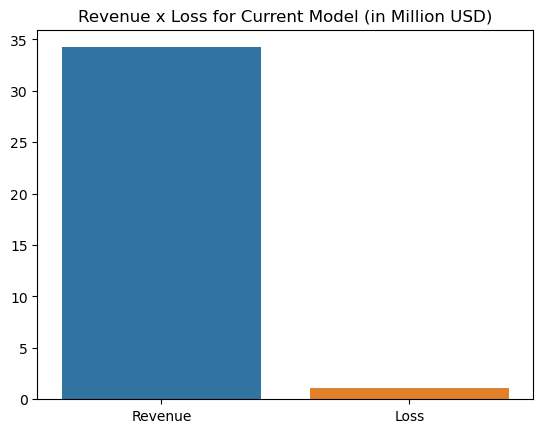

In [174]:
# Plotting the difference
values_current_model = np.array([revenue, loss])/1000000
sns.barplot(x=['Revenue', 'Loss'], y=values_current_model)
plt.title('Revenue x Loss for Current Model (in Million USD)')
plt.show()

With an understanding of the current situation, we can beging to think about how to deliver better results for this company.   
The basic ideal is to modeal a new solution that **maximizes revenue** and **minimizes loss**, when compared with the initial approach.

A initial step would be to **create a first model to estimate how much would a person spend if given a credit card.**   
Thus I would build a **Regressor** before a **Classifier.**
With an estimated expenditure, I could decide whether the application should be accepted or denied.

So far, the dataset presents us with 4 group of rows:

1. Card = 0 & Expenditure = 0
2. Card = 1 & Expenditure = 0 (probably applications just accepted)
3. Card = 1 & Expected Share <= Yearly Income/12 
4. Card = 1 & Expected Share > Yearly Income/12

I will train and test with the groups 3 and 4. Then I can make an educated guess for group 2.   
However, group 1 is different. They are applications denied for an unknown reason to me. My first ideal is to estimate their expenditure as I would normally do plus 1/12 of their yearly income.

To validate my initial assumptions/ideas, I'll proceed with the EDA and will compare **how the group declined is different/similar from the group that was accepted**

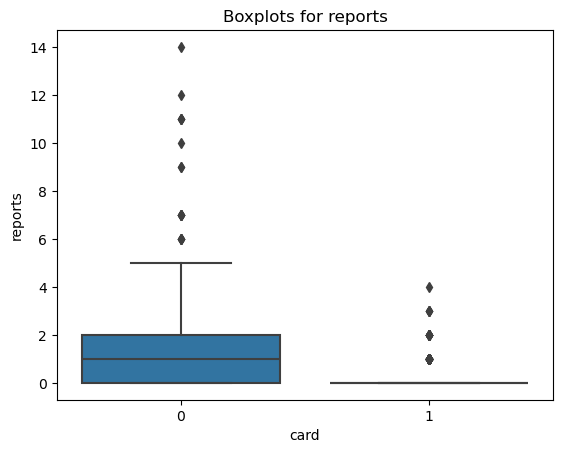

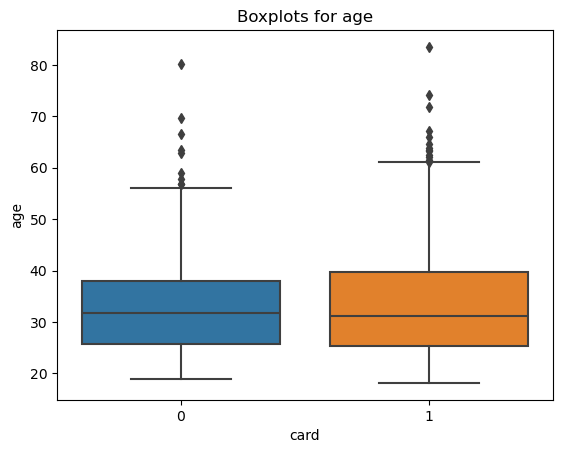

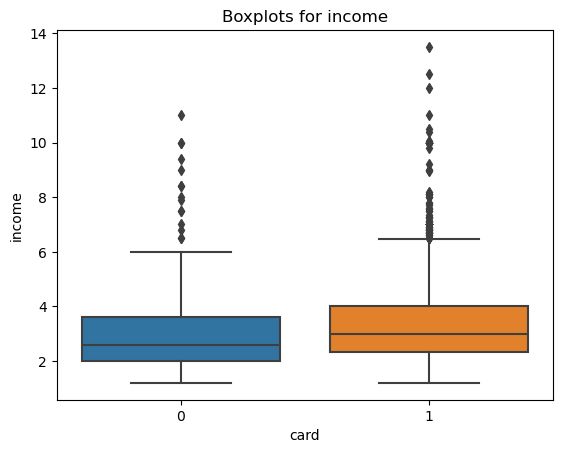

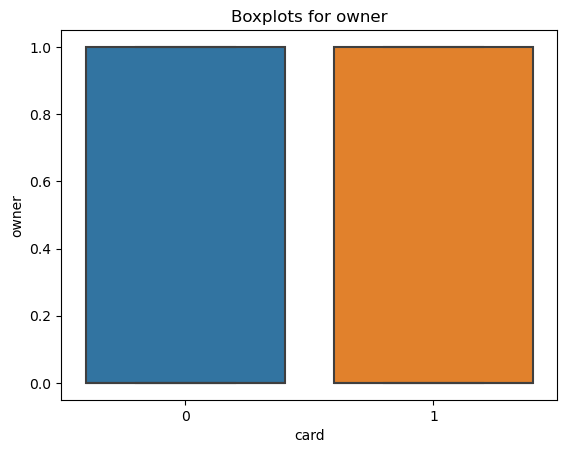

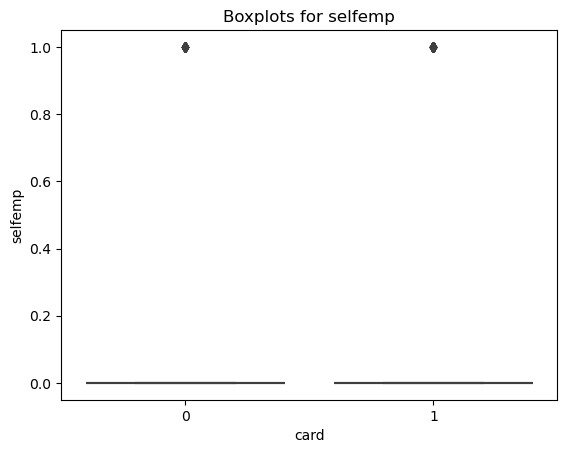

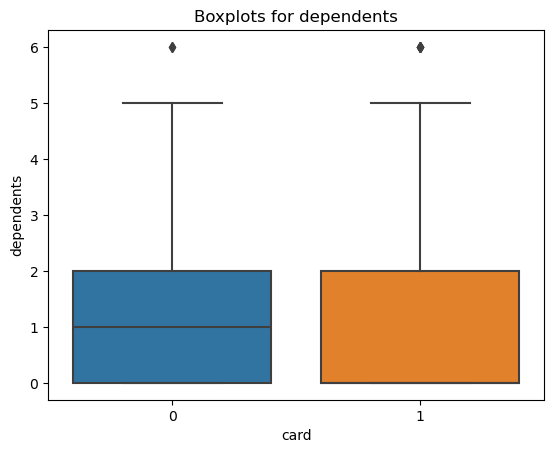

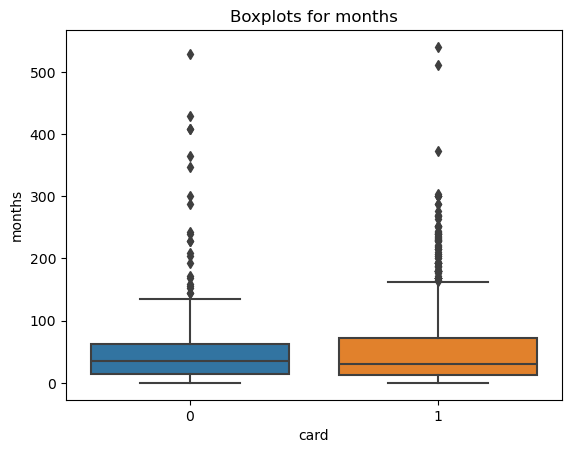

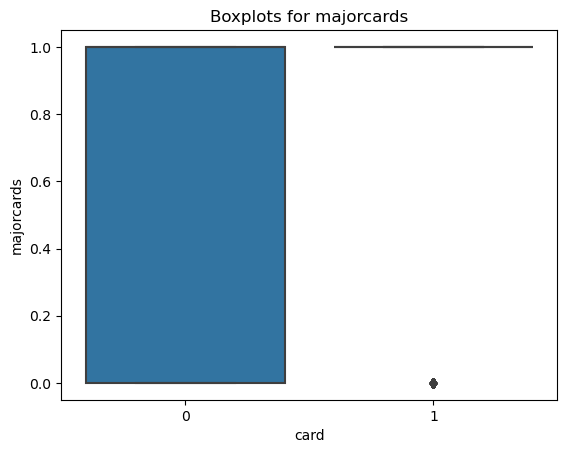

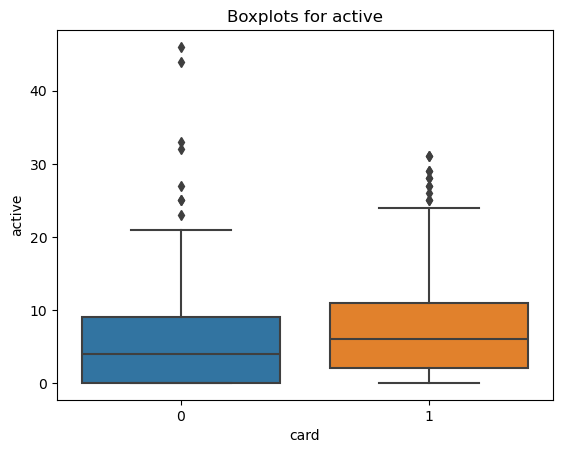

In [175]:
columns_to_compare = ['reports', 'age', 'income', 'owner', 'selfemp', 'dependents', 'months', 'majorcards', 'active']
for col in columns_to_compare:
    sns.boxplot(x=df['card'], y=df[col])
    plt.title(f'Boxplots for {col}')
    plt.show()

**Denied applications seem to have been declined mainly for:**

- having way **more reports**
- and/or having **lower income**
- and/or having **no other majorcards**
- and/or **less active accounts**

I'll do a statistical test to get a better point of view

Checking whether the difference in means is statistically significant between applications denied and accepted:
------------------------------------
Column: reports, p-value: 3.829814386114768e-61, 1 mean: 0.12903225806451613, 0 mean: 1.587837837837838
Column: income, p-value: 3.0907700526997686e-06, 1 mean: 3.4522407624633424, 0 mean: 3.0709077702702707
Column: owner, p-value: 8.02320281039493e-08, 1 mean: 0.47996089931573804, 0 mean: 0.30405405405405406
Column: selfemp, p-value: 0.048542228772949364, 1 mean: 0.06158357771260997, 0 mean: 0.0945945945945946
Column: majorcards, p-value: 9.14053500650036e-05, 1 mean: 0.8396871945259042, 0 mean: 0.7398648648648649
Column: active, p-value: 1.4138701299346246e-05, 1 mean: 7.269794721407624, 0 mean: 6.054054054054054


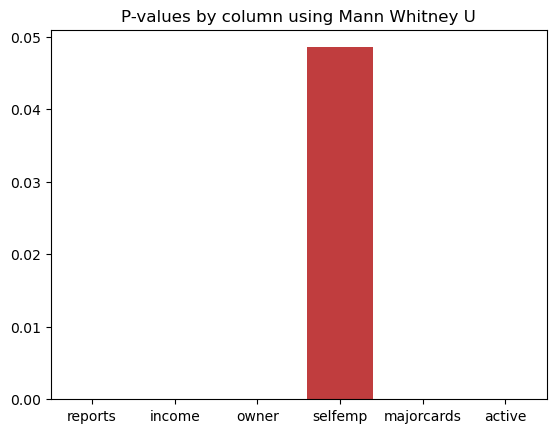

In [176]:
accepted_card = df['card'] == 1
results = {}
print('Checking whether the difference in means is statistically significant between applications denied and accepted:')
print('------------------------------------')
for col in columns_to_compare:
    accepted = df.loc[accepted_card][col]
    denied = df.loc[~accepted_card][col]
    pvalue = stats.mannwhitneyu(accepted, denied)[1]
    if pvalue < 0.05:
        results[col] = pvalue
        print(f'Column: {col}, p-value: {pvalue}, 1 mean: {accepted.mean()}, 0 mean: {denied.mean()}')
#results_df = pd.DataFrame(results, index=results.keys)
#print(results_df.head())
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("P-values by column using Mann Whitney U")
plt.show()

The columns above differ significantly from denied to accepted applications.   
To finish the anlysis of the 0 class, I'll conduct a correlation test as well

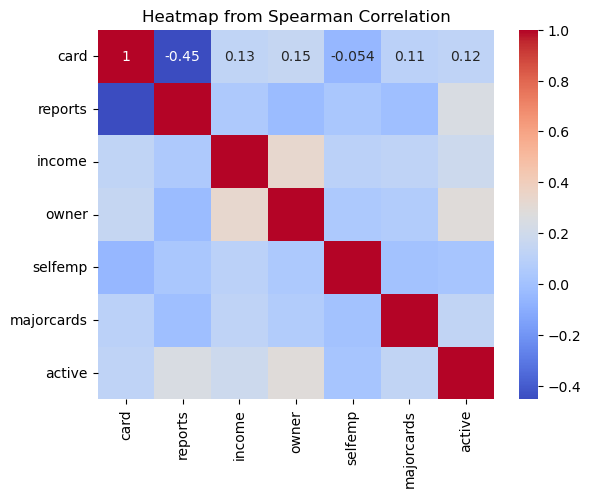

In [177]:
columns_to_correlate = ['card', 'reports', 'income', 'owner', 'selfemp', 'majorcards', 'active']
card_corr = df[columns_to_correlate].corr(method='spearman')
sns.heatmap(card_corr, annot=True, cmap='coolwarm')
plt.title('Heatmap from Spearman Correlation')
plt.show()

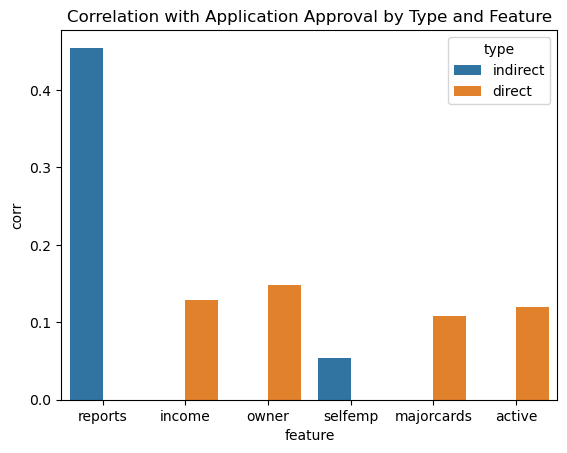

In [178]:
# Showing a barplot
card_corr = card_corr.iloc[0, 1:] # Getting just the correlations with card, excluding its own
indexes = card_corr.index
type_corr = ['direct' if corr > 0 else 'indirect' for corr in card_corr]
card_corr_df = pd.DataFrame({'corr': abs(card_corr), 'type': type_corr}, index=indexes)
sns.barplot(data = card_corr_df, x=indexes, y='corr', hue='type')
plt.xlabel('feature')
plt.title('Correlation with Application Approval by Type and Feature')
plt.show()

In summary, we conclude that **the main factor associated with having the applications denied is the number of major derrogatory reports.**

Now, I'll focus my analysis on the first predictive model: the **expenditure estimator.** Steps will be as follows:  

1. Slice df so it contains only rows where expenses > 0
2. Normalize/Scale variables to be able to have more statistic tests and regression models available
3. Conduct bivariate and multivariate analysis to understand what possibly infleunces expenditure
4. Start pre-processing, selecting a model, training, testing, evaluating, etc.

In [179]:
# Creating df_expenses
df_expenditure = df.loc[df['expenditure']>0].copy()
df_expenditure.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,yearly_expenditure,expected_share,target
0,1,0,37.66667,4.5200,0.033270,124.983300,1,0,3,54,1,12,0.149980,0.033181,2
1,1,0,33.25000,2.4200,0.005217,9.854167,0,0,3,34,1,13,0.011825,0.004886,2
2,1,0,33.66667,4.5000,0.004156,15.000000,1,0,4,58,1,5,0.018000,0.004000,2
3,1,0,30.50000,2.5400,0.065214,137.869200,0,0,0,25,1,7,0.165443,0.065135,2
4,1,0,32.16667,9.7867,0.067051,546.503300,1,0,2,64,1,5,0.655804,0.067010,2


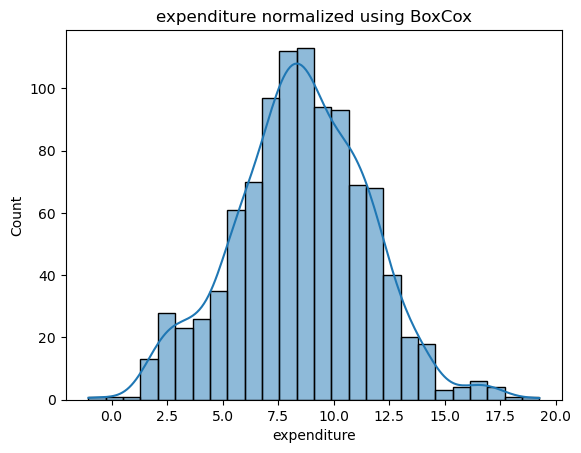

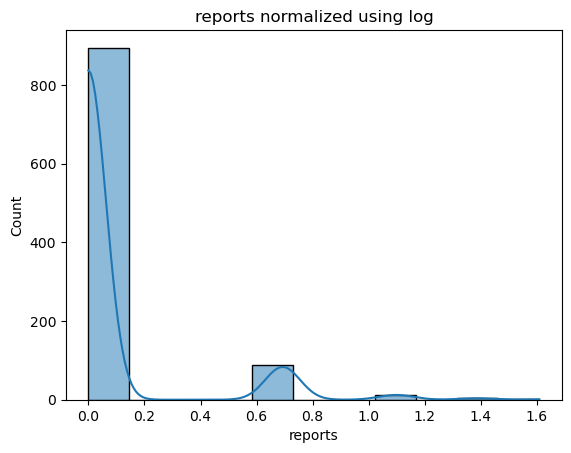

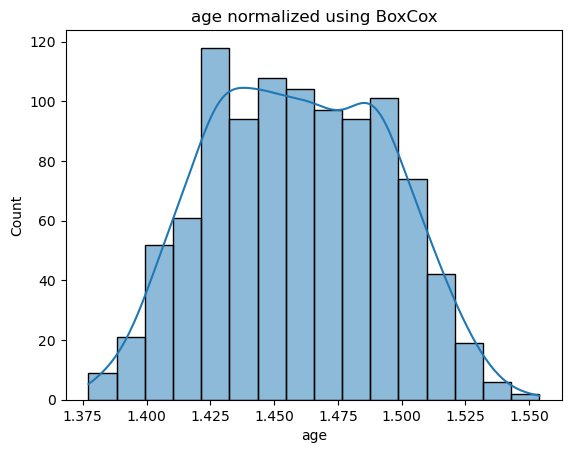

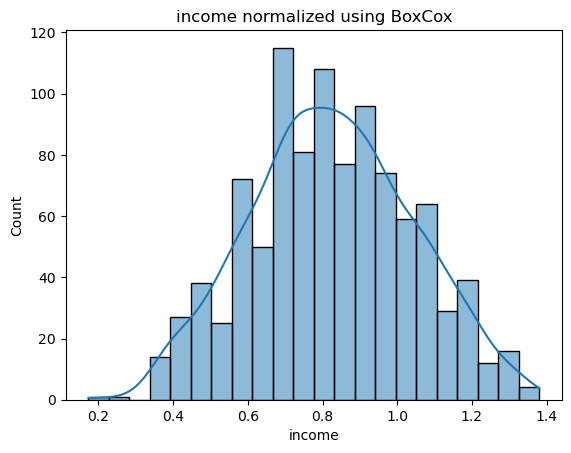

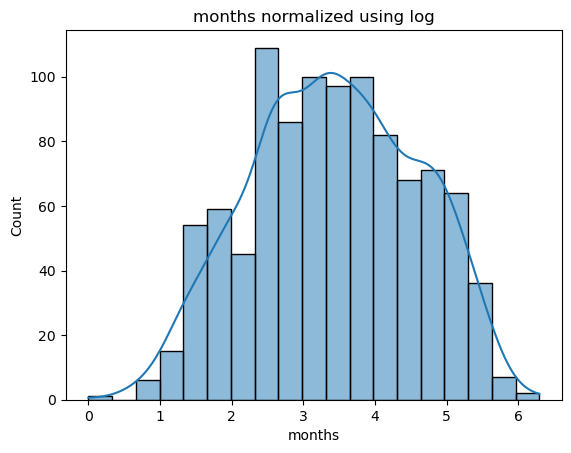

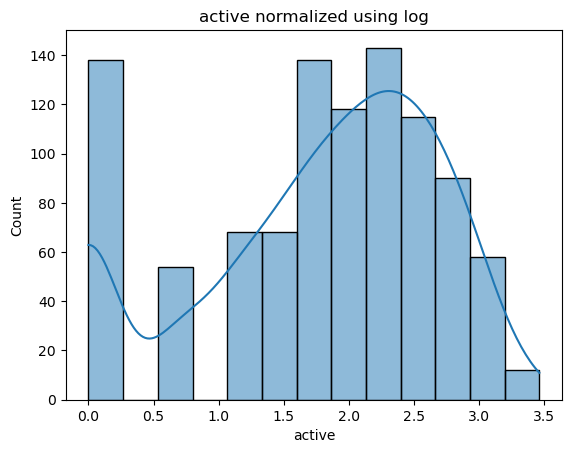

In [180]:
continuous_features = ['expenditure', 'reports', 'age', 'income', 'months', 'active']
for feat in continuous_features:
    if (df_expenditure[feat] > 0).all(): 
        # Normalizing using boxcox
        df_expenditure[feat] = stats.boxcox(df_expenditure[feat])[0]
        sns.histplot(df_expenditure[feat], kde=True)
        plt.title(f'{feat} normalized using BoxCox')
        plt.show()
    else:
        # Normalizing using log
        df_expenditure[feat] = np.log(df_expenditure[feat]+1)
        sns.histplot(df_expenditure[feat], kde=True)
        plt.title(f'{feat} normalized using log')
        plt.show()

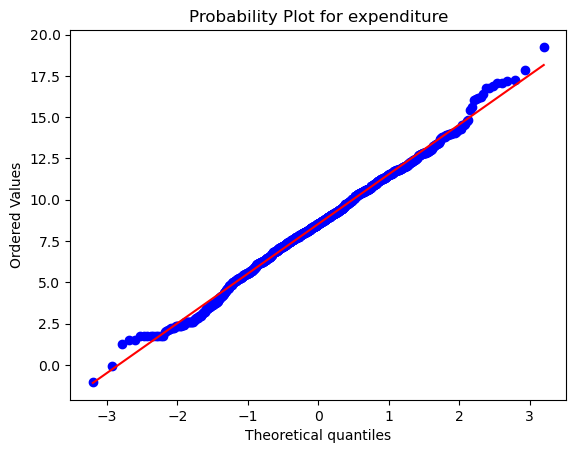

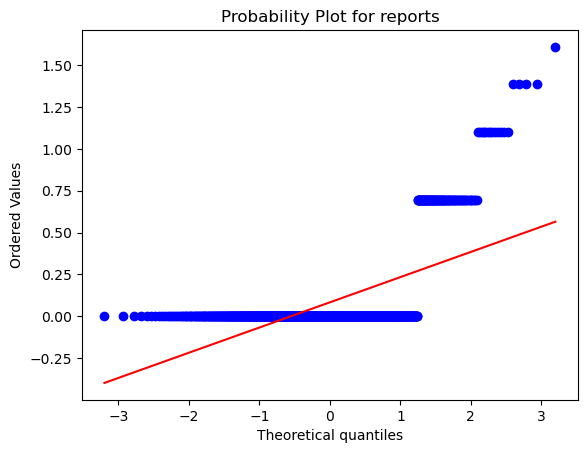

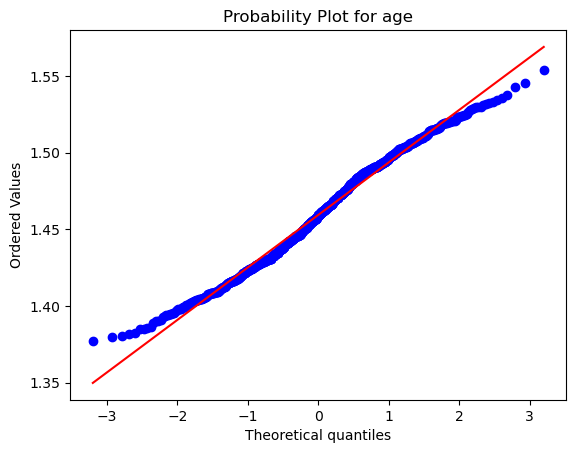

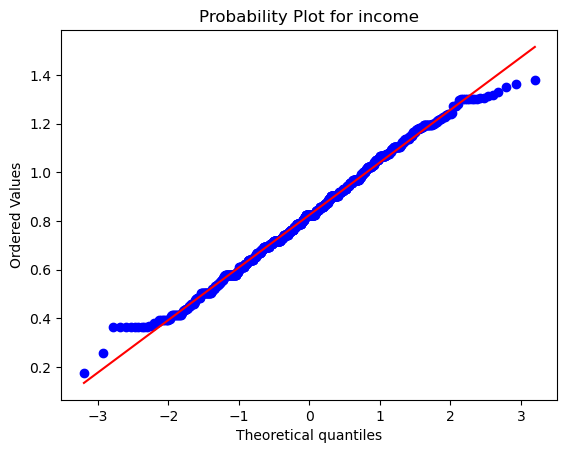

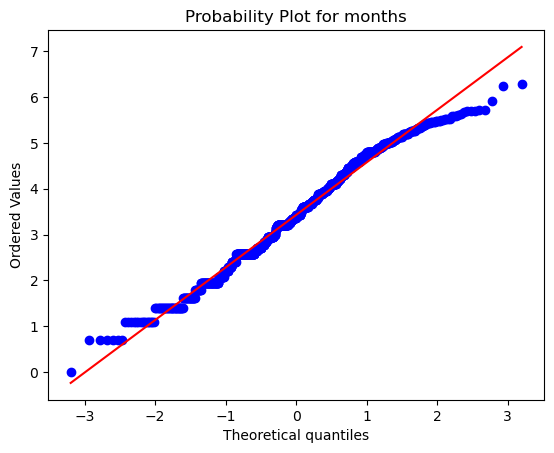

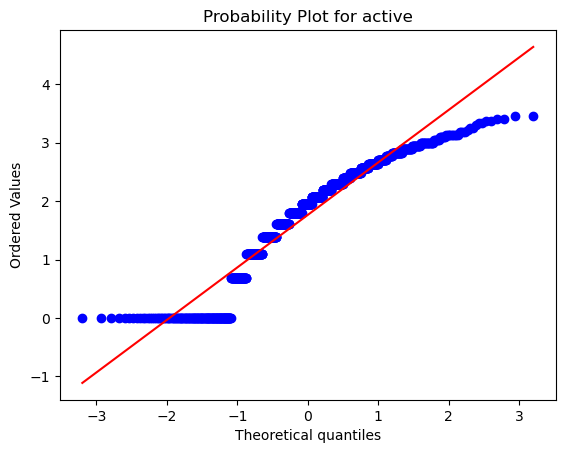

In [181]:
# Verifying transformations
for col in continuous_features:
    stats.probplot(df_expenditure[col], plot=plt)
    plt.title(f'Probability Plot for {col}')
    plt.show()

The columns became approximately normal. Now I will check the correlation between them

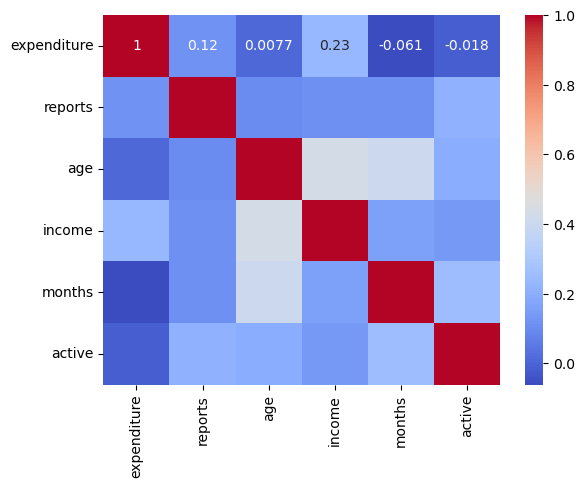

In [182]:
exp_corr = df_expenditure[continuous_features].corr()
sns.heatmap(exp_corr, annot=True, cmap='coolwarm')
plt.show()

There is but a week correlation with income. But it doesn't seem to be very correlated with the other features

In [183]:
# Checking p-value
stats.pearsonr(df_expenditure['expenditure'], df_expenditure['income'])

PearsonRResult(statistic=0.23400038914956295, pvalue=6.271230255260611e-14)

Before I finish, I will do 2 more kind of plots:
1. Scatter plots w/ regression lines between expenditure and continuous features
2. Boxplot between expenditures and discrete/ordinal features

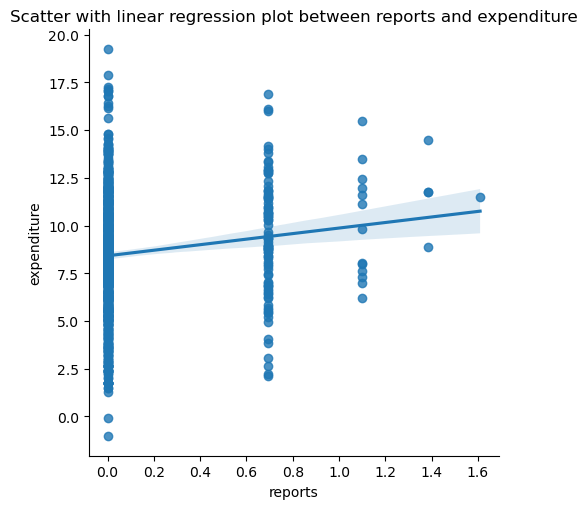

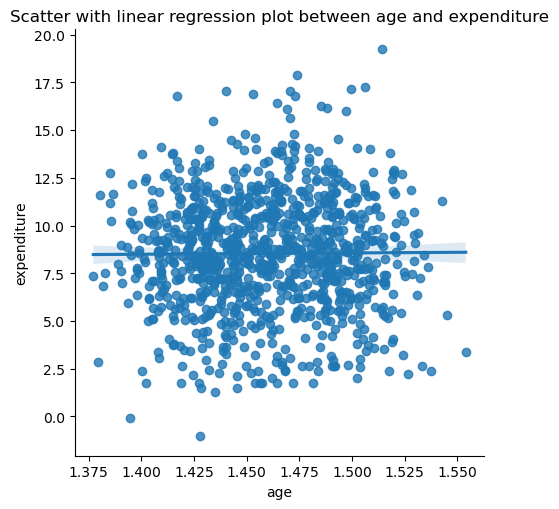

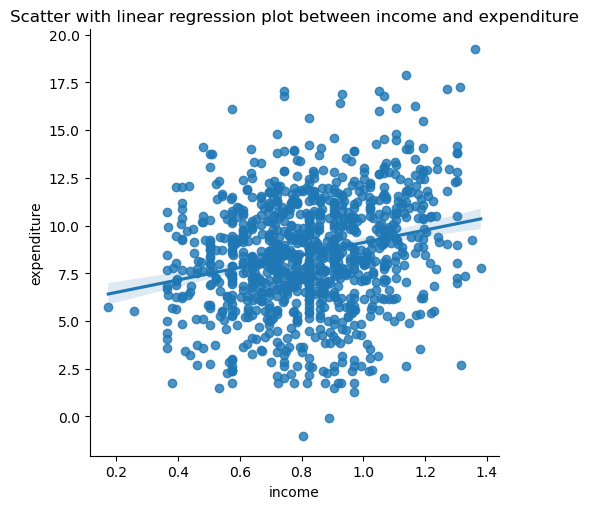

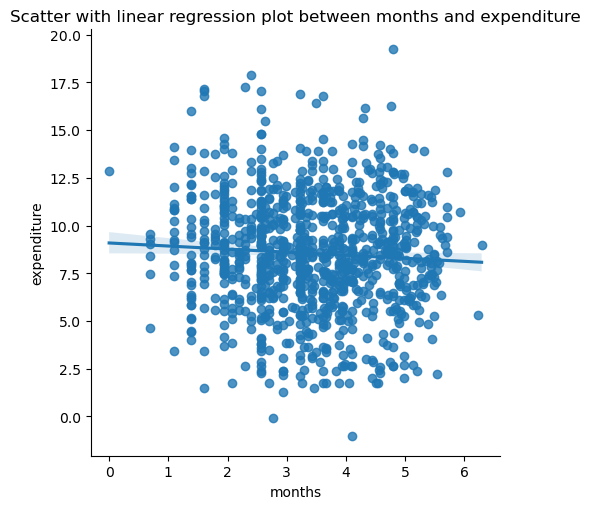

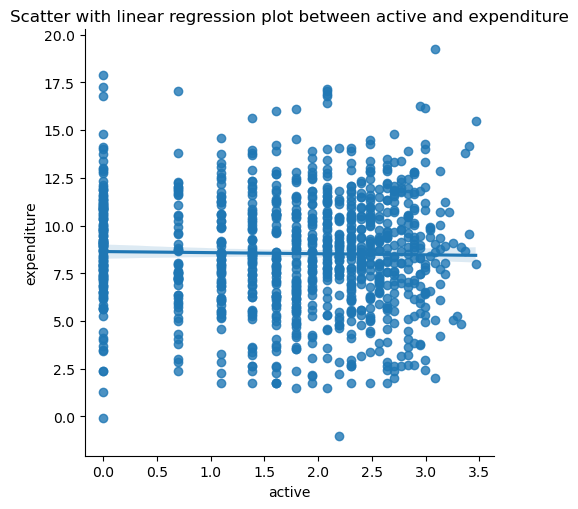

In [184]:
# Verifying continuos features
for col in continuous_features[1:]:
    sns.lmplot(data=df_expenditure, x=col, y='expenditure')
    plt.title(f'Scatter with linear regression plot between {col} and expenditure')
    plt.show()


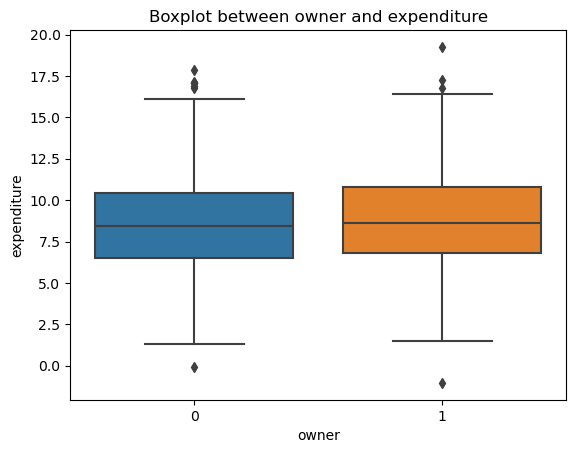

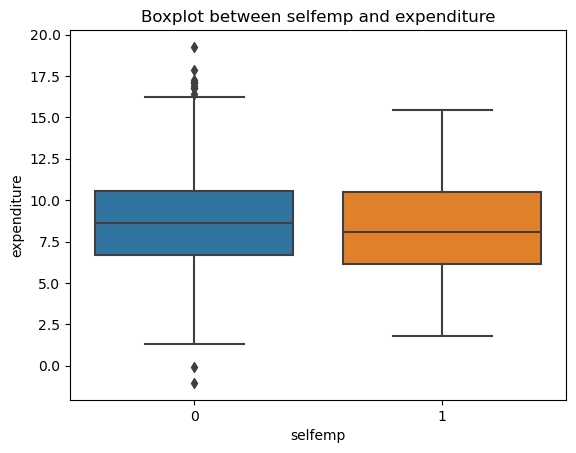

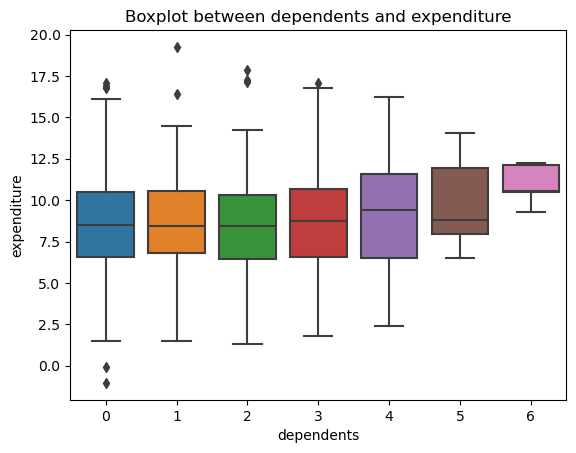

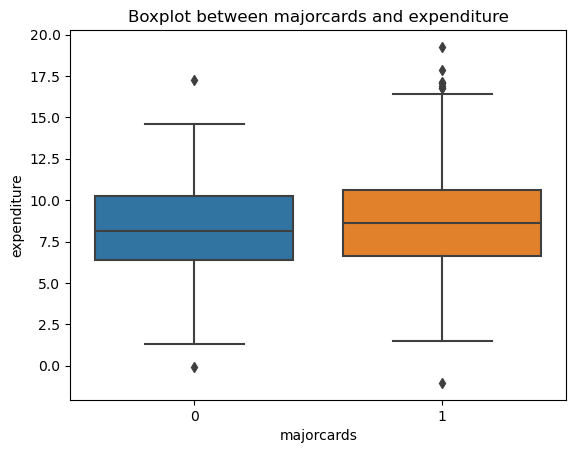

In [185]:
# Discrete / Ordinal columns
for col in ['owner', 'selfemp', 'dependents', 'majorcards']:
    sns.boxplot(data=df_expenditure, x=col, y='expenditure')
    plt.title(f"Boxplot between {col} and expenditure")
    plt.show()

---

# 3. First Model: Regression!

After this initial analysis to understand how to predict expenditure, I decided to select a few features that seemed mostly associated with my target. They are:

- income 
- reports
- dependents

Although it may sound simple, I'm willing to start with a simpler model and, if needed, do more feature engineering to enhance it.

In [186]:
# Dividing into X and y
rows_with_expenditure = df['expenditure'] > 0
X = df.loc[rows_with_expenditure, ['income', 'reports', 'dependents']]
y = df.loc[rows_with_expenditure, 'expenditure']

My process will be:
1. Create a Pipeline to normalize, scale and center the data
2. Divide the data into training and testing
3. Pre-process the train data 
4. Test a couple models to select the one I will optmize
    * I though about linear regression (the simplest) or Ridge (applies regularization while mantains the number of features)
    * A non-linear model like RandomForest
5. Retrain, test and optmize

In [187]:
# Importing necessary modules
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, RobustScaler, MinMaxScaler # normalization and scaling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score # training and validation
from sklearn.metrics import mean_squared_error, r2_score # evaluation

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

After all importations, the regression pipeline and grid can be created with:

In [188]:
# Create a regression pipeline
regression_pipeline = Pipeline(
    steps=[
        ('normalizer', PowerTransformer()),
        ('scaler', RobustScaler()),
        ('model', LinearRegression()) #placeholder
    ]
)

# Creating a grid of regression models
regression_grid = [
    {'model': [LinearRegression()]},
    {'model': [Ridge()]},
    {'model': [RandomForestRegressor()]}
]

Now, I can create a regression searcher with GridSearchCV.   
I will be using the 10-fold cross validation just for more robusteness.   
And since it's a preliminary model with linear and non-linear, I'll be using r² as my metric 

In [189]:
# Creating Regression Searcher
reg_searcher = GridSearchCV(regression_pipeline, regression_grid, verbose=1, cv=10, scoring='r2')

With all necessary classes instantiated, I'll divide into train and test and compare between estimators:

In [190]:
# Dividing into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=21)

reg_searcher.fit(X_train, y_train)
print(f"Best estimator: {reg_searcher.best_estimator_}")
print(f"Best R² score: {reg_searcher.best_score_}")
pd.DataFrame(reg_searcher.cv_results_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best estimator: Pipeline(steps=[('normalizer', PowerTransformer()), ('scaler', RobustScaler()),
                ('model', Ridge())])
Best R² score: 0.047870671917477126


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010591,0.005248,0.002378,0.002646,LinearRegression(),{'model': LinearRegression()},0.082743,-0.028192,0.042156,0.002844,0.026441,-0.062993,0.135929,0.112237,0.045006,0.122284,0.047845,0.062653,2
1,0.008744,0.007378,0.007110,0.005837,Ridge(),{'model': Ridge()},0.082538,-0.028107,0.042215,0.003006,0.026727,-0.062736,0.135916,0.112205,0.045004,0.121940,0.047871,0.062518,1
2,0.190852,0.038094,0.012238,0.005570,RandomForestRegressor(),{'model': RandomForestRegressor()},-0.311043,-0.574426,-0.096306,-0.383127,-0.259585,-0.257886,-0.037161,-0.426170,-0.144232,-0.302624,-0.279256,0.152385,3


Ridge Regression seemed the best estimator from the ones I chose.   
Interestingly, none of them explained well the variance in expenditure (only 5% explained).   
It might suggest I need more features in the model, and maybe that linear will work better than non-linear.

Before I retest it, I'll take a closer look at the pre-processing:

Distribution is normal? False, p-value was 0.0010025299009036731


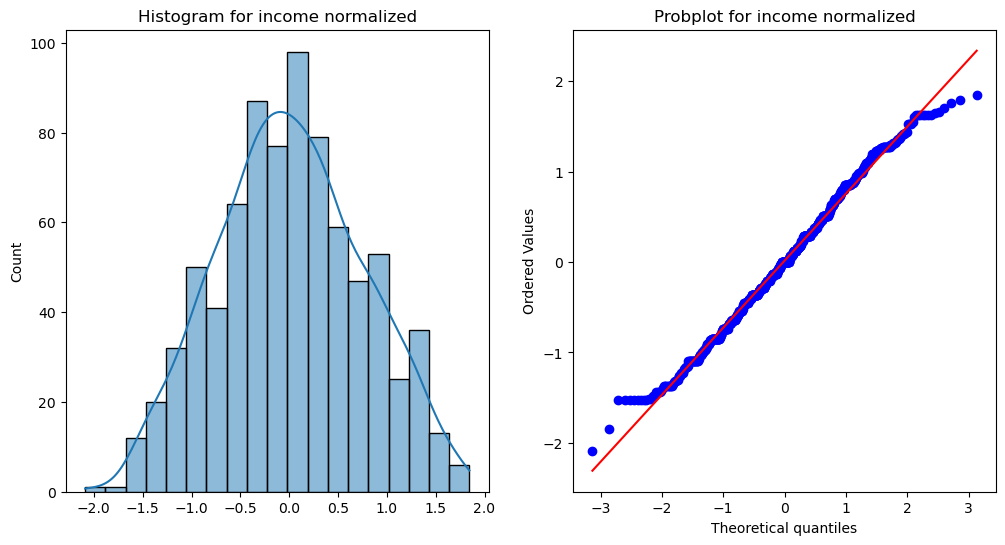

Distribution is normal? False, p-value was 2.8165321769168026e-46


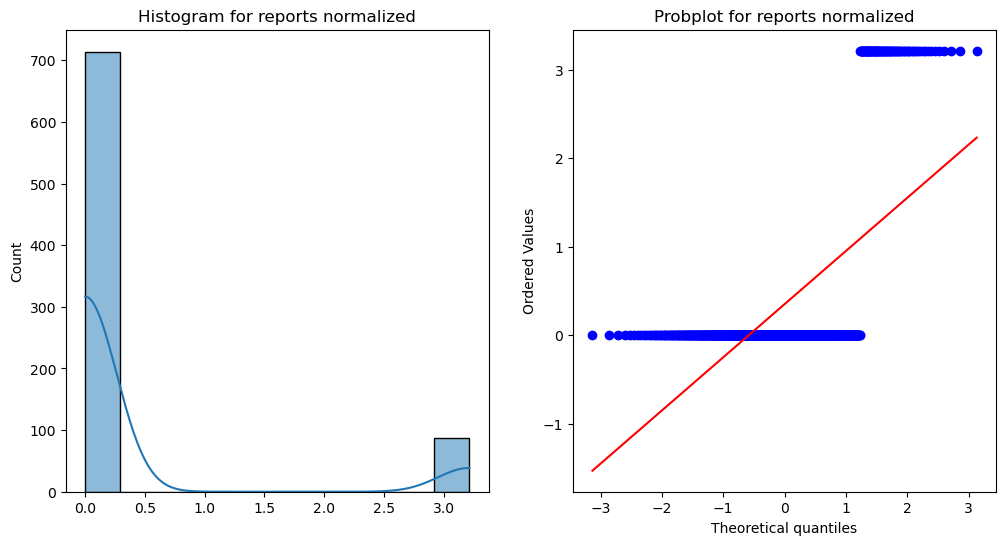

Distribution is normal? False, p-value was 2.024828581179042e-32


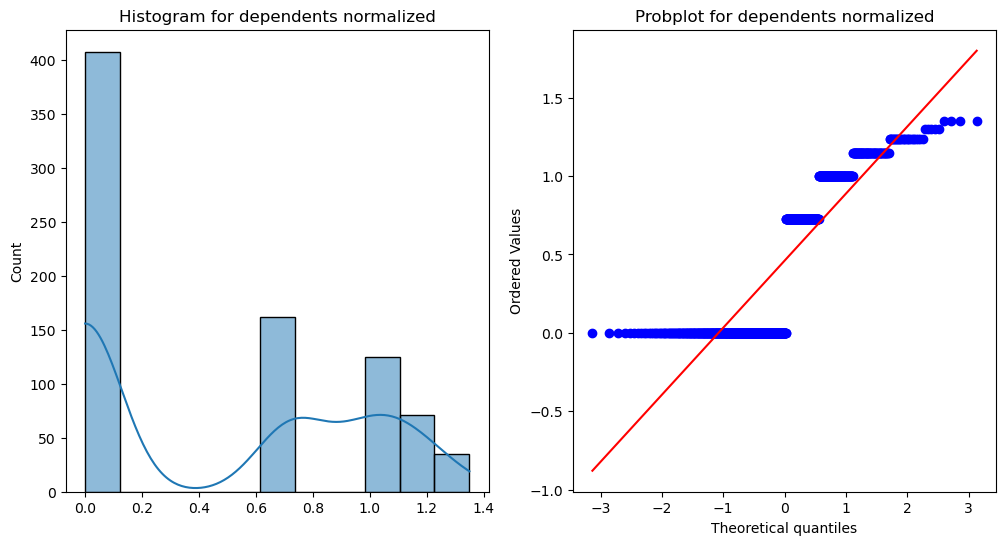

In [191]:
# Analyzing the pre-processing
norm = PowerTransformer()
X_train_norm = norm.fit_transform(X_train)
scaler = RobustScaler()
X_train_norm_scaled = scaler.fit_transform(X_train_norm)
for index in range(0, len(X_train.columns)):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    feature_transformed = X_train_norm_scaled[:, index]

    sns.histplot(feature_transformed, kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram for {X_train.columns[index]} normalized")

    stats.probplot(feature_transformed, plot=axes[1])
    axes[1].set_title(f"Probplot for {X_train.columns[index]} normalized")

    pvalue = stats.shapiro(feature_transformed).pvalue
    null_hypotesis = pvalue > 0.05 # Distribution is normal
    print(f"Distribution is normal? {null_hypotesis}, p-value was {pvalue}")

    plt.show()

Income isn't 100% normalized yet, while it's closer.   
The other features are distributted in a range of values slightly different, so I might test a more standard scaler.

In [192]:
# Retesting with different parameters and features

# Changing features
X = df.loc[rows_with_expenditure, ['income', 'reports', 'dependents', 'age', 'months', 'active']]

# Changing pipeline
regression_pipeline = Pipeline(
    steps=[
        ('normalizer', PowerTransformer()),
        ('scaler', MinMaxScaler()),
        ('model', LinearRegression()) #placeholder
    ]
)

# Changing Models
regression_grid = [
    {'model': [LinearRegression()]},
    {'model': [Ridge()]},
    {'model': [Lasso()]},
    {'model': [GradientBoostingRegressor()]}
]

# Receating Regression Searcher
reg_searcher = GridSearchCV(regression_pipeline, regression_grid, verbose=1, cv=10, scoring='r2')

# Dividing into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=21)

reg_searcher.fit(X_train, y_train)
print(f"Best estimator: {reg_searcher.best_estimator_}")
print(f"Best R² score: {reg_searcher.best_score_}")
pd.DataFrame(reg_searcher.cv_results_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best estimator: Pipeline(steps=[('normalizer', PowerTransformer()), ('scaler', MinMaxScaler()),
                ('model', Lasso())])
Best R² score: 0.058354330238032256


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022670,0.008341,0.001809,0.001960,LinearRegression(),{'model': LinearRegression()},0.100800,-0.009126,0.009097,0.015872,0.075824,-0.065729,0.162456,0.108453,0.051060,0.120899,0.056961,0.066016,3
1,0.018309,0.005648,0.005392,0.007378,Ridge(),{'model': Ridge()},0.096814,-0.005340,0.009592,0.019587,0.075972,-0.060640,0.161673,0.109130,0.050358,0.120432,0.057758,0.064073,2
2,0.018437,0.004786,0.003367,0.005294,Lasso(),{'model': Lasso()},0.091973,0.003735,0.019691,0.018048,0.070451,-0.052676,0.152231,0.108103,0.052807,0.119179,0.058354,0.058928,1
3,0.158155,0.014952,0.002156,0.004081,GradientBoostingRegressor(),{'model': GradientBoostingRegressor()},-0.194121,-0.064230,-0.041394,-0.039495,0.080538,-0.110926,-0.092346,-0.143934,0.033212,-0.185998,-0.075870,0.084412,4


In [193]:
# Checking the error just to understand how far I am
pred = reg_searcher.predict(X_test)
mean_squared_error(y_test, pred)

67212.89183361726

For me, it's clear I have to step back for a moment and do a better pre-processing since all models so far have performed poorly.    
One starting point, may be retreating outliers, but more carefully now.    
They might be the reason for a poor performance because the model is training trying to fit them.

My process will be:
1. Understand the % of outliers per column
2. Decide if I remove or replace them 

In [194]:
# Selecting columns for outlier treatment
df_outliers = df.loc[rows_with_expenditure, ['reports', 'age', 'income', 'expenditure', 'dependents', 'months', 'active']].copy()

In [195]:
# Creating function based on IQR:
def outlier_per_column(df: pd.DataFrame):
    """Uses IQR to determine the % of a column composed by outliers"""
    print("% of Outliers per column:")
    print("---"*10)
    for col in df.columns:
        q1 = df[col].quantile(.25)
        q3  = df[col].quantile(.75)
        iqr =  q3 - q1
        outliers = (df[col] > q3 + 1.5*iqr) | (df[col] < q1 - 1.5*iqr)
        print(f"{col}: {df.loc[outliers].shape[0] * 100 / df.shape[0]: .2f}%")

outlier_per_column(df_outliers)

% of Outliers per column:
------------------------------
reports:  10.68%
age:  1.40%
income:  7.09%
expenditure:  5.29%
dependents:  0.50%
months:  7.68%
active:  1.10%


Since there are columns with around 10% outliers, I'll decide to replace outliers in the entire df by the upper/lower fence.

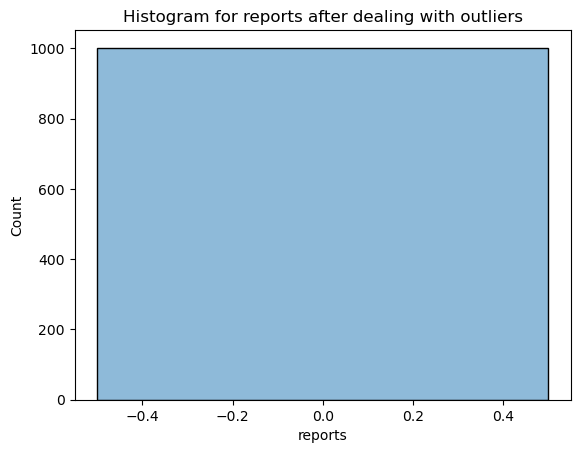

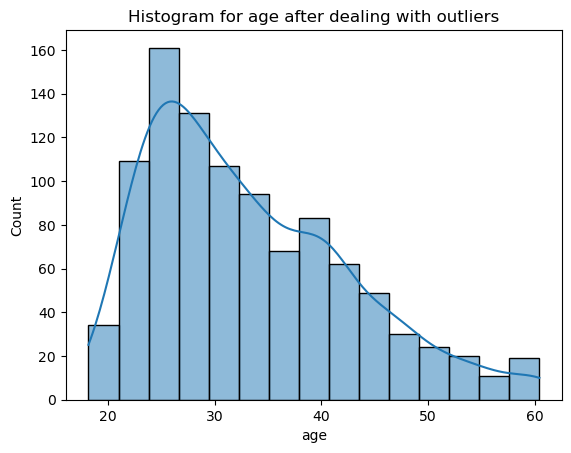

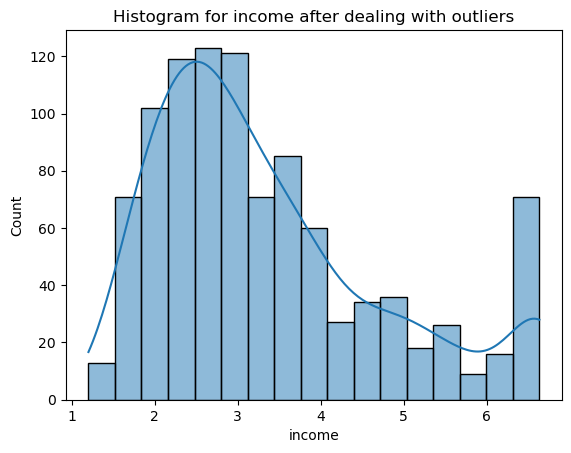

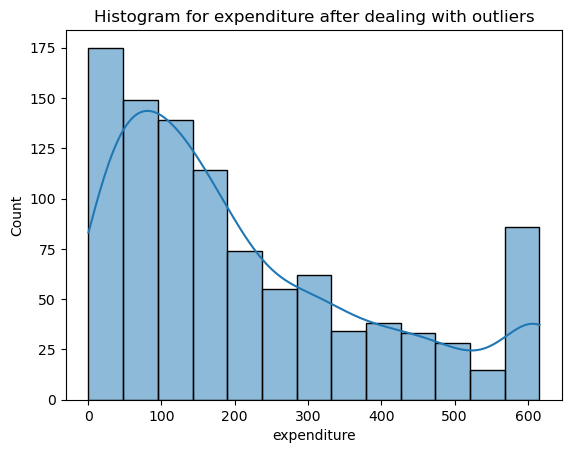

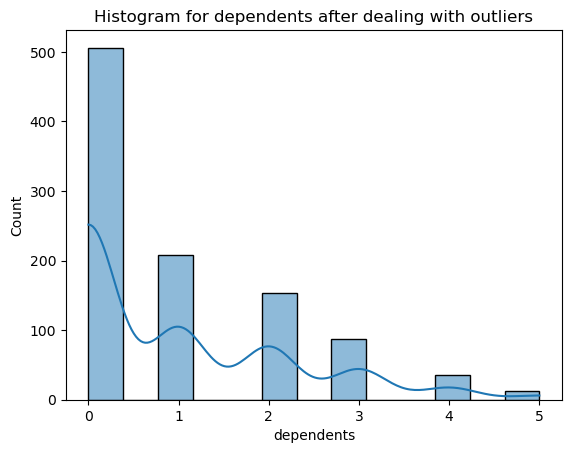

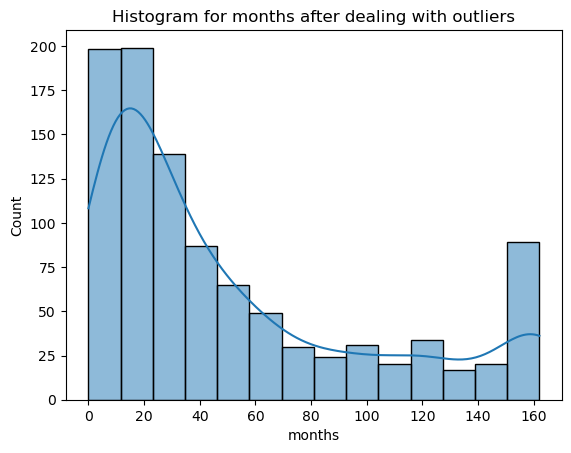

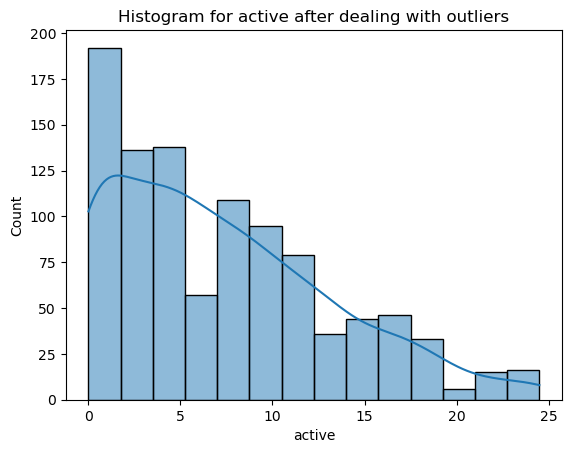

% of Outliers per column:
------------------------------
reports:  0.00%
age:  0.00%
income:  7.09%
expenditure:  0.00%
dependents:  0.00%
months:  0.00%
active:  0.00%


In [196]:
for col in df_outliers.columns:
    q1 = df[col].quantile(.25)
    q3  = df[col].quantile(.75)
    iqr =  q3 - q1
    upper_fence = q3 + iqr * 1.5
    lower_fence = q1 - iqr * 1.5
    # replacing upper
    df_outliers.loc[df_outliers[col] > upper_fence, col] = upper_fence
    # replacing lower
    df_outliers.loc[df_outliers[col] < lower_fence, col] = lower_fence
    #ploting distribution
    sns.histplot(df_outliers[col], kde=True)
    plt.title(f"Histogram for {col} after dealing with outliers")
    plt.show()

outlier_per_column(df_outliers)


In [197]:
df_outliers.income.describe()

count    1002.000000
mean        3.363543
std         1.393701
min         1.200000
25%         2.350000
50%         3.000000
75%         4.000000
max         6.634375
Name: income, dtype: float64

Now, let's retrain and retest the models

In [198]:
X = df_outliers[['reports', 'age', 'income', 'dependents', 'months', 'active']]
y = df_outliers['expenditure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=21)

# Just reusing the regression_pipeline using Linear Regression
regression_pipeline.fit(X_train, y_train)
pred = regression_pipeline.predict(X_test)
r2_score(y_test, pred)

0.02605517833653037

## 4. Jumping to the Classification

Just testing how classification would work without expenditure

In [199]:
X = df[['reports', 'age', 'income', 'owner', 'selfemp', 'dependents', 'months', 'majorcards', 'active']]
y = df['target']

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=21)

In [236]:
pw = PowerTransformer()
X_train[['reports', 'age', 'income', 'dependents', 'months', 'active']] = pw.fit_transform(X_train[['reports', 'age', 'income', 'dependents', 'months', 'active']])
X_test[['reports', 'age', 'income', 'dependents', 'months', 'active']] = pw.transform(X_test[['reports', 'age', 'income', 'dependents', 'months', 'active']])

In [237]:
from sklearn.ensemble import RandomForestClassifier

In [238]:
rdc = RandomForestClassifier(class_weight='balanced_subsample')

In [239]:
rdc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample')

In [240]:
pred = rdc.predict(X_test)

In [241]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [242]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.56      0.57      0.56       130
           1       0.57      0.56      0.57       134

    accuracy                           0.56       264
   macro avg       0.56      0.56      0.56       264
weighted avg       0.56      0.56      0.56       264



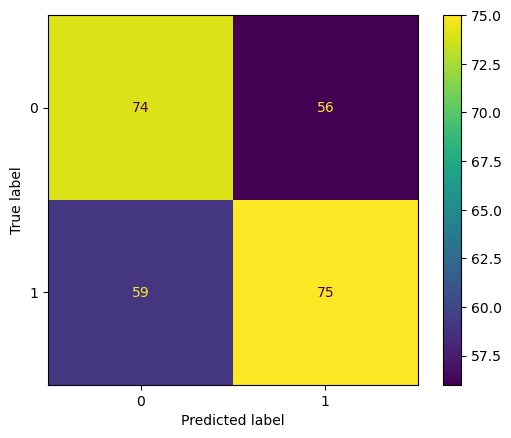

In [243]:
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [244]:
cm

array([[74, 56],
       [59, 75]], dtype=int64)

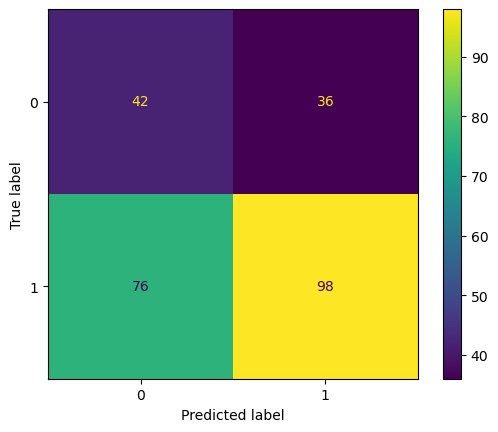

In [233]:
# Avaluating performance for 1 against "not 1"
TP = cm[2, 2]
FP = cm[0, 2] + cm[1, 2]
FN = cm[2, 0] + cm[2, 1]
TN = np.sum(cm) - (TP + FP + FN + cm[1, 1])

# Criando a matriz de 1 x não 1
cm_1_vs_all = np.array([[TN, FN],
                        [FP, TP]])

ConfusionMatrixDisplay(cm_1_vs_all).plot()

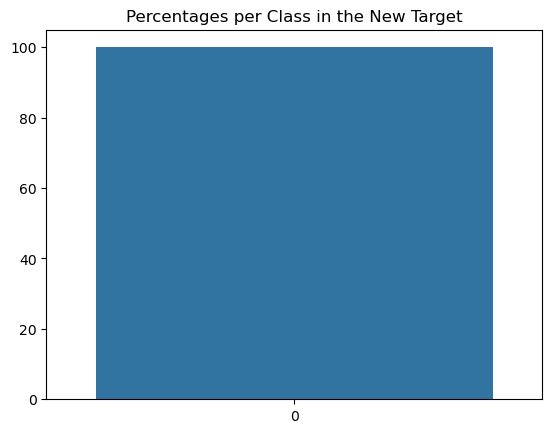

In [234]:
# Trying to transform in a binary classification since beginning
df['target'] = (df['target']==2).astype(int)
percentages = df['target'].value_counts() / df.shape[0] * 100
sns.barplot(x=percentages.index, y=percentages.values)
plt.title("Percentages per Class in the New Target")
plt.show()

In [212]:
# Redividing X and y
X = df[['reports', 'age', 'income', 'owner', 'selfemp', 'dependents', 'months', 'majorcards', 'active']].copy()
y = df['target'].copy()

In [213]:
continuous = ['age', 'income', 'active', 'months']
non_binary = ['reports', 'dependents']

In [214]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [215]:
# Retreating outliers
def replace_outliers(df):
    for col in df.columns:
        q1 = df[col].quantile(.25)
        q3 = df[col].quantile(.75)
        fence = 1.5 * (q3-q1)
        upper_fence = q3 + fence
        lower_fence = q1 - fence
        df.loc[df[col] > upper_fence, col] = upper_fence
        df.loc[df[col] < lower_fence, col] = lower_fence

In [216]:
continuous_pipeline = Pipeline(
    steps=[
        ('norm', PowerTransformer()),
        ('scaler', MinMaxScaler())
    ]
)

non_binary_pipeline = Pipeline(steps=[('scaler', MinMaxScaler())])

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=21)

In [218]:
#Fitting
continuous_pipeline.fit(X_train[continuous])
non_binary_pipeline.fit(X_train[non_binary])

Pipeline(steps=[('scaler', MinMaxScaler())])

In [219]:
#Transforming
X_train[continuous] = continuous_pipeline.transform(X_train[continuous])
X_train[non_binary] = non_binary_pipeline.transform(X_train[non_binary])
X_test[continuous] = continuous_pipeline.transform(X_test[continuous])
X_test[non_binary] = non_binary_pipeline.transform(X_test[non_binary])

In [220]:
logistic_params = {
    'class_weight': ["balanced", None], # target is 70% 0, only 30% 1
    'C': [.1, 1, 10], # testing default, less or more regularization
    'solver': ['lbfgs', 'liblinear', 'sag'], # testing default, one for small datasets and one for large
    'penalty': ['l2'] # l2 penalty 
}

opt_lr = GridSearchCV(
    LogisticRegression(random_state=21), 
    logistic_params,
    scoring='f1', # I want it to capture all 1s
    cv=10,
    verbose=1)

opt_lr.fit(X_train, y_train)
print(f"Best estimator: {opt_lr.best_estimator_}")
print(f"Best params: {opt_lr.best_params_}")
print(f"Best score: {opt_lr.best_score_}")

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best estimator: LogisticRegression(C=10, class_weight='balanced', random_state=21, solver='sag')
Best params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}
Best score: 0.6709985806919039


In [221]:
knneighbors_params = {
    'n_neighbors': [3, 5, 7], # testing default, less or more regularization
    'weights': ['uniform', 'distance'], # testing default and another weight
}

opt_knn = GridSearchCV(
    KNeighborsClassifier(), 
    knneighbors_params,
    scoring='recall', # I want it to capture all 1s
    cv=10,
    verbose=1)

opt_knn.fit(X_train, y_train)
print(f"Best estimator: {opt_knn.best_estimator_}")
print(f"Best params: {opt_knn.best_params_}")
print(f"Best score: {opt_knn.best_score_}")

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best estimator: KNeighborsClassifier(n_neighbors=7)
Best params: {'n_neighbors': 7, 'weights': 'uniform'}
Best score: 0.6409125188536954


KNN might have performed poorly because I wasn't able to balance classes

In [222]:
rf_params = {
    'n_estimators': [50, 100, 150], # testing default, less or more regularization
    'class_weight': ['balanced', 'balanced_subsample', None], # testing default and another weight
    'min_samples_split': [2, 5, 10],
    'oob_score': [True, False]
}

opt_rf = GridSearchCV(
    RandomForestClassifier(random_state=21), 
    rf_params,
    scoring='recall', # I want it to capture all 1s
    cv=5,
    verbose=1)

opt_rf.fit(X_train, y_train)
print(f"Best estimator: {opt_rf.best_estimator_}")
print(f"Best params: {opt_rf.best_params_}")
print(f"Best score: {opt_rf.best_score_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best estimator: RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=50, oob_score=True, random_state=21)
Best params: {'class_weight': 'balanced', 'min_samples_split': 10, 'n_estimators': 50, 'oob_score': True}
Best score: 0.7045369678864825


It clearly is a problem for the **Logistic Regressor!**

In [223]:
classifier = LogisticRegression(random_state=21, class_weight="balanced")

In [224]:
X_train

,reports,age,income,owner,selfemp,dependents,months,majorcards,active
575,0.000000,0.253754,0.513527,1,0,0.000000,0.621944,1,0.238913
582,0.000000,0.149801,0.153616,1,0,0.000000,0.464205,1,0.511477
126,0.000000,0.289210,0.746318,0,0,0.000000,0.548777,1,0.618056
1285,0.142857,0.546567,0.380567,0,0,0.166667,0.677136,1,0.238913
196,0.000000,0.167923,0.415758,1,0,0.166667,0.794015,1,0.287357
...,...,...,...,...,...,...,...,...,...
368,0.000000,0.618635,0.602190,1,0,0.333333,0.726634,0,0.557297
48,0.000000,0.322408,0.404377,0,0,0.166667,0.511772,0,0.180989
772,0.000000,0.556314,0.832830,1,0,0.000000,0.280630,1,0.000000
1231,0.000000,0.392268,0.496030,0,0,0.000000,0.495483,1,0.671664


In [225]:
classifier.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=21)

              precision    recall  f1-score   support

           0       0.62      0.57      0.59       130
           1       0.61      0.66      0.63       134

    accuracy                           0.61       264
   macro avg       0.61      0.61      0.61       264
weighted avg       0.61      0.61      0.61       264



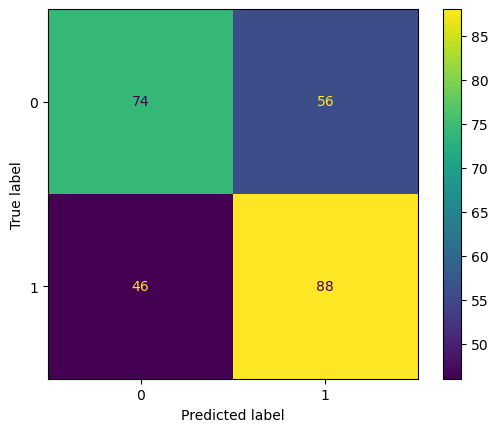

In [226]:
# 1st analysis
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

In [227]:
from sklearn.metrics import precision_recall_curve

In [228]:
y_proba = classifier.predict_proba(X_test)[:,1]

In [229]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

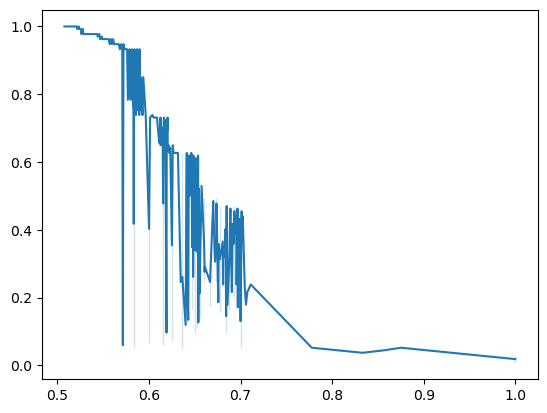

In [230]:
sns.lineplot(x=precision, y=recall)
plt.show()

In [231]:
# Maximizing recall
best_threshold_index = np.argmax(recall)
best_threshold = threshold[best_threshold_index]
best_recall = recall[best_threshold_index]
best_precision = precision[best_threshold_index]

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Recall with best threshold: {best_recall:.2f}')
print(f'Precision with best threshold: {best_precision:.2f}')

TypeError: 'float' object is not subscriptable

In [ ]:
# Testing 10% just to increase a little bit precision
y_pred_new_threshold = (y_proba > .1).astype(int)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       192
           1       0.27      1.00      0.43        72

    accuracy                           0.27       264
   macro avg       0.14      0.50      0.21       264
weighted avg       0.07      0.27      0.12       264



c:\Users\vsuar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vsuar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vsuar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


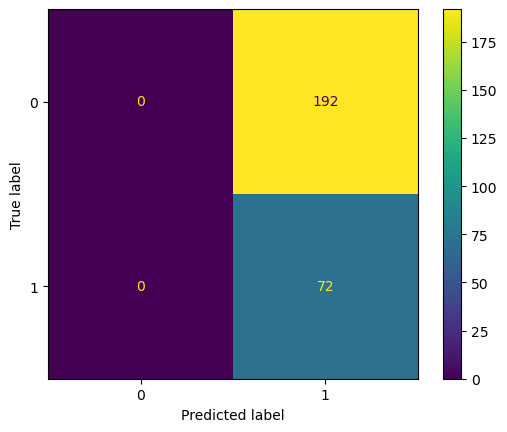

In [ ]:
print(classification_report(y_test, y_pred_new_threshold))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_new_threshold)).plot()
plt.show()

In [ ]:
df[non_binary]

,reports,dependents
0,0,3
1,0,3
2,0,4
3,0,0
4,0,2
...,...,...
1314,0,0
1315,5,3
1316,0,2
1317,0,0


In [ ]:
# Testing normal y_pred
df_continuous = df[continuous].copy()
df_non_binary = df[non_binary].copy()

df_continuous = pd.DataFrame(continuous_pipeline.transform(df_continuous), columns=df_continuous.columns)
df_non_binary = pd.DataFrame(non_binary_pipeline.transform(df_non_binary), columns = df_non_binary.columns)

X = pd.concat([df_continuous, df_non_binary, df[['owner', 'selfemp', 'majorcards']]], axis=1)

# Reordering columns
X = X[['reports', 'age', 'income',	'owner',	'selfemp',	'dependents',	'months',	'majorcards',	'active']]

# Adding new column
df['pred'] = classifier.predict(X)

In [ ]:
df['card'].value_counts() / df.shape[0]

1    0.775588
0    0.224412
Name: card, dtype: float64

In [ ]:
df['pred'].value_counts() / df.shape[0]

1    0.507961
0    0.492039
Name: pred, dtype: float64

In [ ]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active',
       'yearly_expenditure', 'expected_share', 'target', 'pred'],
      dtype='object')